In [228]:
# Main Libraries

import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
from sys import platform
from xgboost import XGBRegressor
import joblib
import h2o
from h2o.automl import H2OAutoML


# Sklearn Library

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso # regularization
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier # DecisionTreeRegressor
from sklearn.svm import SVC 
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso # regularization
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier # DecisionTreeRegressor
from sklearn.svm import SVC 
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [229]:
warnings.filterwarnings("ignore")

In [230]:
# All data without the manually inputted next 10 matches.

alldata = pd.read_csv("coding-csv/merged_datasets.csv", index_col=[0]).iloc[10:-10]

# This season's data.

thisseason = alldata[alldata["date"]>"2023-08-01"]

# Data previous to this season.

previousto = alldata[alldata["date"]<"2023-08-01"]

# Next 10 matches (manually inputted).

to_predict = pd.read_csv("coding-csv/merged_datasets.csv", index_col=[0]).iloc[-10:]
to_predict_id = to_predict[["ID"]]

In [231]:
thisseasonodds = thisseason[["B365H", "B365D", "B365A"]]

In [232]:
alldata["result"]

10      1.0
11      1.0
12      0.0
13      1.0
14      0.5
       ... 
2414    1.0
2415    0.0
2416    1.0
2417    0.5
2418    0.5
Name: result, Length: 2409, dtype: float64

In [233]:
dataframes = [alldata, thisseason, previousto, to_predict]

In [234]:
for i in dataframes:
    i.drop(["BWH", "BWD", "BWA", "IWD", "IWH", "IWA", "WHH", "WHD", "WHA", "VCH", "VCD", "VCA"], axis=1, inplace=True)

In [235]:
# Add manually B365's odds for every new match.

x = 2419

to_predict.loc[x, "B365H"] = 2.45
to_predict.loc[x, "B365D"] = 3.00
to_predict.loc[x, "B365A"] = 3.00

to_predict.loc[x+1, "B365H"] = 2.00
to_predict.loc[x+1, "B365D"] = 3.10
to_predict.loc[x+1, "B365A"] = 4.20

to_predict.loc[x+2, "B365H"] = 4.20
to_predict.loc[x+2, "B365D"] = 4.00
to_predict.loc[x+2, "B365A"] = 1.80

to_predict.loc[x+3, "B365H"] = 3.30
to_predict.loc[x+3, "B365D"] = 3.40
to_predict.loc[x+3, "B365A"] = 2.20

to_predict.loc[x+4, "B365H"] = 2.80
to_predict.loc[x+4, "B365D"] = 3.00
to_predict.loc[x+4, "B365A"] = 2.63

to_predict.loc[x+5, "B365H"] = 1.22
to_predict.loc[x+5, "B365D"] = 6.00
to_predict.loc[x+5, "B365A"] = 11.00

to_predict.loc[x+6, "B365H"] = 4.75
to_predict.loc[x+6, "B365D"] = 3.75
to_predict.loc[x+6, "B365A"] = 1.70

to_predict.loc[x+7, "B365H"] = 2.88
to_predict.loc[x+7, "B365D"] = 3.10
to_predict.loc[x+7, "B365A"] = 2.45

to_predict.loc[x+8, "B365H"] = 1.50
to_predict.loc[x+8, "B365D"] = 5.00
to_predict.loc[x+8, "B365A"] = 5.00

to_predict.loc[x+9, "B365H"] = 2.38
to_predict.loc[x+9, "B365D"] = 3.10
to_predict.loc[x+9, "B365A"] = 3.20

to_predict.head(1)

,ID,date,home_team,home_goals_offense,home_goals_defense,home_offense,home_in_game,home_defense,away_team,away_goals_offense,...,away_standing,home_win_streak,home_lose_streak,away_win_streak,away_lose_streak,home_draw_streak,away_draw_streak,B365H,B365D,B365A
2419,2023-12-08-Getafe-Valencia,2023-12-08,Getafe,1.3,1.1,0.63,0.59,0.56,Valencia,1.0,...,8,1,0,0,0,0,1,2.45,3.0,3.0


In [236]:
for i in dataframes:
    i.dropna(inplace=True)
    i.drop(["ID", "date", "home_team", "away_team"], axis=1, inplace=True)

alldata = pd.concat([alldata.drop("result", axis=1), alldata["result"]], axis=1)
thisseason = pd.concat([thisseason.drop("result", axis=1), thisseason["result"]], axis=1)
previousto = pd.concat([previousto.drop("result", axis=1), previousto["result"]], axis=1)
to_predict = pd.concat([to_predict.drop("result", axis=1), to_predict["result"]], axis=1)

In [237]:
scaler = StandardScaler()

alldataresults = alldata[["result"]]
alldata = pd.DataFrame(scaler.fit_transform(alldata[alldata.columns[:-1]]), columns=alldata.columns[:-1])

thisseasonresults = thisseason[["result"]]
thisseason = pd.DataFrame(scaler.fit_transform(thisseason[thisseason.columns[:-1]]), columns=thisseason.columns[:-1])

previoustoresults = previousto[["result"]]
previousto = pd.DataFrame(scaler.fit_transform(previousto[previousto.columns[:-1]]), columns=previousto.columns[:-1])

to_predictresults = to_predict[["result"]]
to_predict = pd.DataFrame(scaler.fit_transform(to_predict[to_predict.columns[:-1]]), columns=to_predict.columns[:-1])

In [238]:
alldata = pd.concat([alldata, alldataresults.reset_index(drop=True)], axis=1)
thisseason = pd.concat([thisseason, thisseasonresults.reset_index(drop=True)], axis=1)
previousto = pd.concat([previousto, previoustoresults.reset_index(drop=True)], axis=1)
to_predict = pd.concat([to_predict, to_predictresults.reset_index(drop=True)], axis=1)

In [239]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,6 hours 34 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,7 months and 8 days
H2O_cluster_name:,H2O_from_python_marcf_27o2t1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.227 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [241]:
train, test = train_test_split(previousto, test_size=0.2, random_state=42)

train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [242]:
X = train.columns
y = "result"
X.remove(y)

In [243]:
automl = H2OAutoML(max_models=10, seed=1)
automl.train(x=X, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = automl.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
lb

AutoML progress: |█
17:25:42.110: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_4_20231206_172542,0.386488,0.149373,0.333669,0.268254,0.149373
StackedEnsemble_AllModels_1_AutoML_4_20231206_172542,0.386593,0.149454,0.333147,0.268746,0.149454
StackedEnsemble_BestOfFamily_1_AutoML_4_20231206_172542,0.386619,0.149474,0.333245,0.268643,0.149474
GLM_1_AutoML_4_20231206_172542,0.388791,0.151158,0.335296,0.270208,0.151158
GBM_5_AutoML_4_20231206_172542,0.392132,0.153767,0.335072,0.272162,0.153767
GBM_2_AutoML_4_20231206_172542,0.393386,0.154752,0.338061,0.272871,0.154752
DeepLearning_1_AutoML_4_20231206_172542,0.393839,0.155109,0.334635,0.272247,0.155109
GBM_grid_1_AutoML_4_20231206_172542_model_1,0.396102,0.156897,0.340341,0.274308,0.156897
XRT_1_AutoML_4_20231206_172542,0.397276,0.157828,0.336217,0.273985,0.157828
GBM_3_AutoML_4_20231206_172542,0.397827,0.158267,0.340895,0.275378,0.158267


In [244]:
mymodel = h2o.get_model('StackedEnsemble_AllModels_1_AutoML_4_20231206_172542')
mymodel

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/10
# GBM base models (used / total),2/6
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [245]:
h2o_df = h2o.H2OFrame(previousto[previousto.columns[:-1]])
predictions = mymodel.predict(h2o_df)

# Convert H2OFrame to pandas DataFrame
pred_df = predictions.as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [155]:
r2_score(alldataresults, pred_df), mean_absolute_error(alldataresults, pred_df)

(0.32335758647273727, 0.29686974342111866)

In [246]:
h2o_df = h2o.H2OFrame(thisseason[thisseason.columns[:-1]])
predictions = mymodel.predict(h2o_df)

# Convert H2OFrame to pandas DataFrame
pred_df = predictions.as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


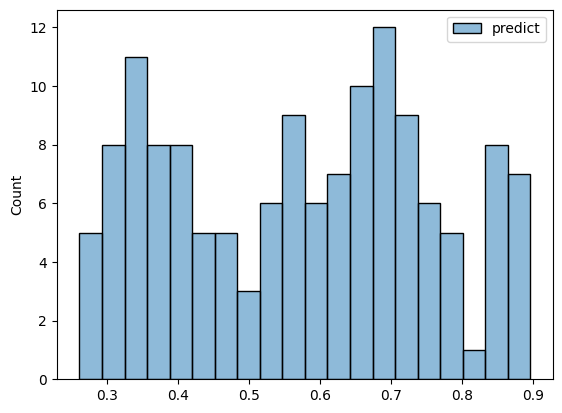

In [162]:
sns.histplot(pred_df, bins=20);

In [247]:
results = pd.concat([thisseason, pred_df], axis=1)
results = pd.concat([results[["predict", "result"]], thisseasonodds.reset_index(drop=True)], axis=1)

In [277]:
bet = 10
margin = 0.8

results['profit'] = np.where((results['predict'] > margin) & (results['result'] == 1), (results['B365H'] * bet) - bet, np.where((results['predict'] > margin) & (results['result'] != 1), -bet, np.where((results['predict'] < ( 1 - margin)) & (results['result'] == 0), (results['B365A'] * bet) - bet, np.where((results['predict'] < ( 1 - margin)) & (results['result'] != 0), -bet, 0))))

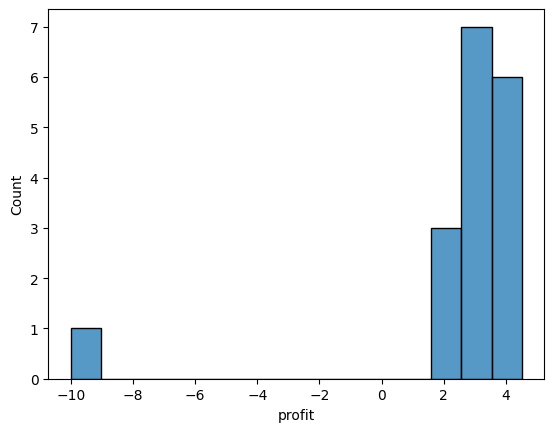

In [278]:
sns.histplot(results[results["profit"]!=0]["profit"], bins = 15);

In [279]:
results.profit.sum()

41.40000000000001

In [280]:
len(results[results["profit"]!=0]["profit"])

17

In [214]:
h2o_df = h2o.H2OFrame(to_predict[to_predict.columns[:-1]])
predictions = mymodel.predict(h2o_df)

# Convert H2OFrame to pandas DataFrame
pred_df = predictions.as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [226]:
nextweek = pd.concat([to_predict_id.reset_index(drop=True), pred_df], axis=1)

In [227]:
nextweek

,ID,predict
0,2023-12-08-Getafe-Valencia,0.605563
1,2023-12-09-Alavés-Las Palmas,0.658559
2,2023-12-09-Real Betis-Real Madrid,0.302216
3,2023-12-09-Villarreal-Real Sociedad,0.433928
4,2023-12-09-Mallorca-Sevilla,0.551135
5,2023-12-10-Atlético Madrid-Almería,0.875083
6,2023-12-10-Granada-Athletic Club,0.327276
7,2023-12-10-Cádiz-Osasuna,0.524051
8,2023-12-10-Barcelona-Girona,0.754169
9,2023-12-11-Rayo Vallecano-Celta Vigo,0.575634


In [297]:
correlation = pd.read_csv("tables/fbref.com/22-23.csv", index_col=[0])

In [298]:
correlation

,team,matchday,date,time,location,opponent,score,score_against,xg_against,xG,...,dispossession_after_tackle,double_yellows,fouls,offsides,penalty_kicks_won,penalty_kicks_conceded,own_goals,recoveries,aerials_won,aerials_lost
0,Osasuna,1,2022-08-12,21:00:00,Home,Sevilla,2,1,0.9,1.50,...,5.0,0.0,16.0,5.0,1.0,0.0,0.0,33.0,8.0,18.0
1,Sevilla,1,2022-08-12,21:00:00,Away,Osasuna,1,2,1.5,0.82,...,6.0,0.0,9.0,2.0,0.0,1.0,0.0,36.0,18.0,8.0
0,Celta Vigo,1,2022-08-13,17:00:00,Home,Espanyol,2,2,1.1,0.40,...,13.0,0.0,17.0,1.0,0.0,1.0,0.0,53.0,24.0,26.0
1,Espanyol,1,2022-08-13,17:00:00,Away,Celta Vigo,2,2,0.4,0.35,...,10.0,0.0,15.0,0.0,1.0,0.0,0.0,62.0,26.0,24.0
0,Valladolid,1,2022-08-13,19:00:00,Home,Villarreal,0,3,1.5,0.99,...,9.0,0.0,6.0,2.0,0.0,0.0,0.0,51.0,10.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Cádiz,38,2023-06-04,21:00:00,Away,Elche,1,1,1.6,1.54,...,6.0,0.0,18.0,3.0,0.0,0.0,0.0,50.0,13.0,12.0
0,Celta Vigo,38,2023-06-04,21:00:00,Home,Barcelona,2,1,1.2,1.26,...,7.0,0.0,9.0,3.0,0.0,0.0,0.0,39.0,15.0,5.0
1,Barcelona,38,2023-06-04,21:00:00,Away,Celta Vigo,1,2,0.7,0.65,...,8.0,0.0,13.0,7.0,0.0,0.0,0.0,53.0,5.0,15.0
0,Espanyol,38,2023-06-04,21:00:00,Home,Almería,3,3,1.8,1.73,...,13.0,0.0,12.0,0.0,1.0,0.0,0.0,48.0,22.0,9.0


In [299]:
correlation.drop(["team", "matchday", "date", "time", "opponent", "location"], axis=1, inplace=True)

In [304]:
x = correlation.corr()
x = x[["score"]].sort_values(by="score")

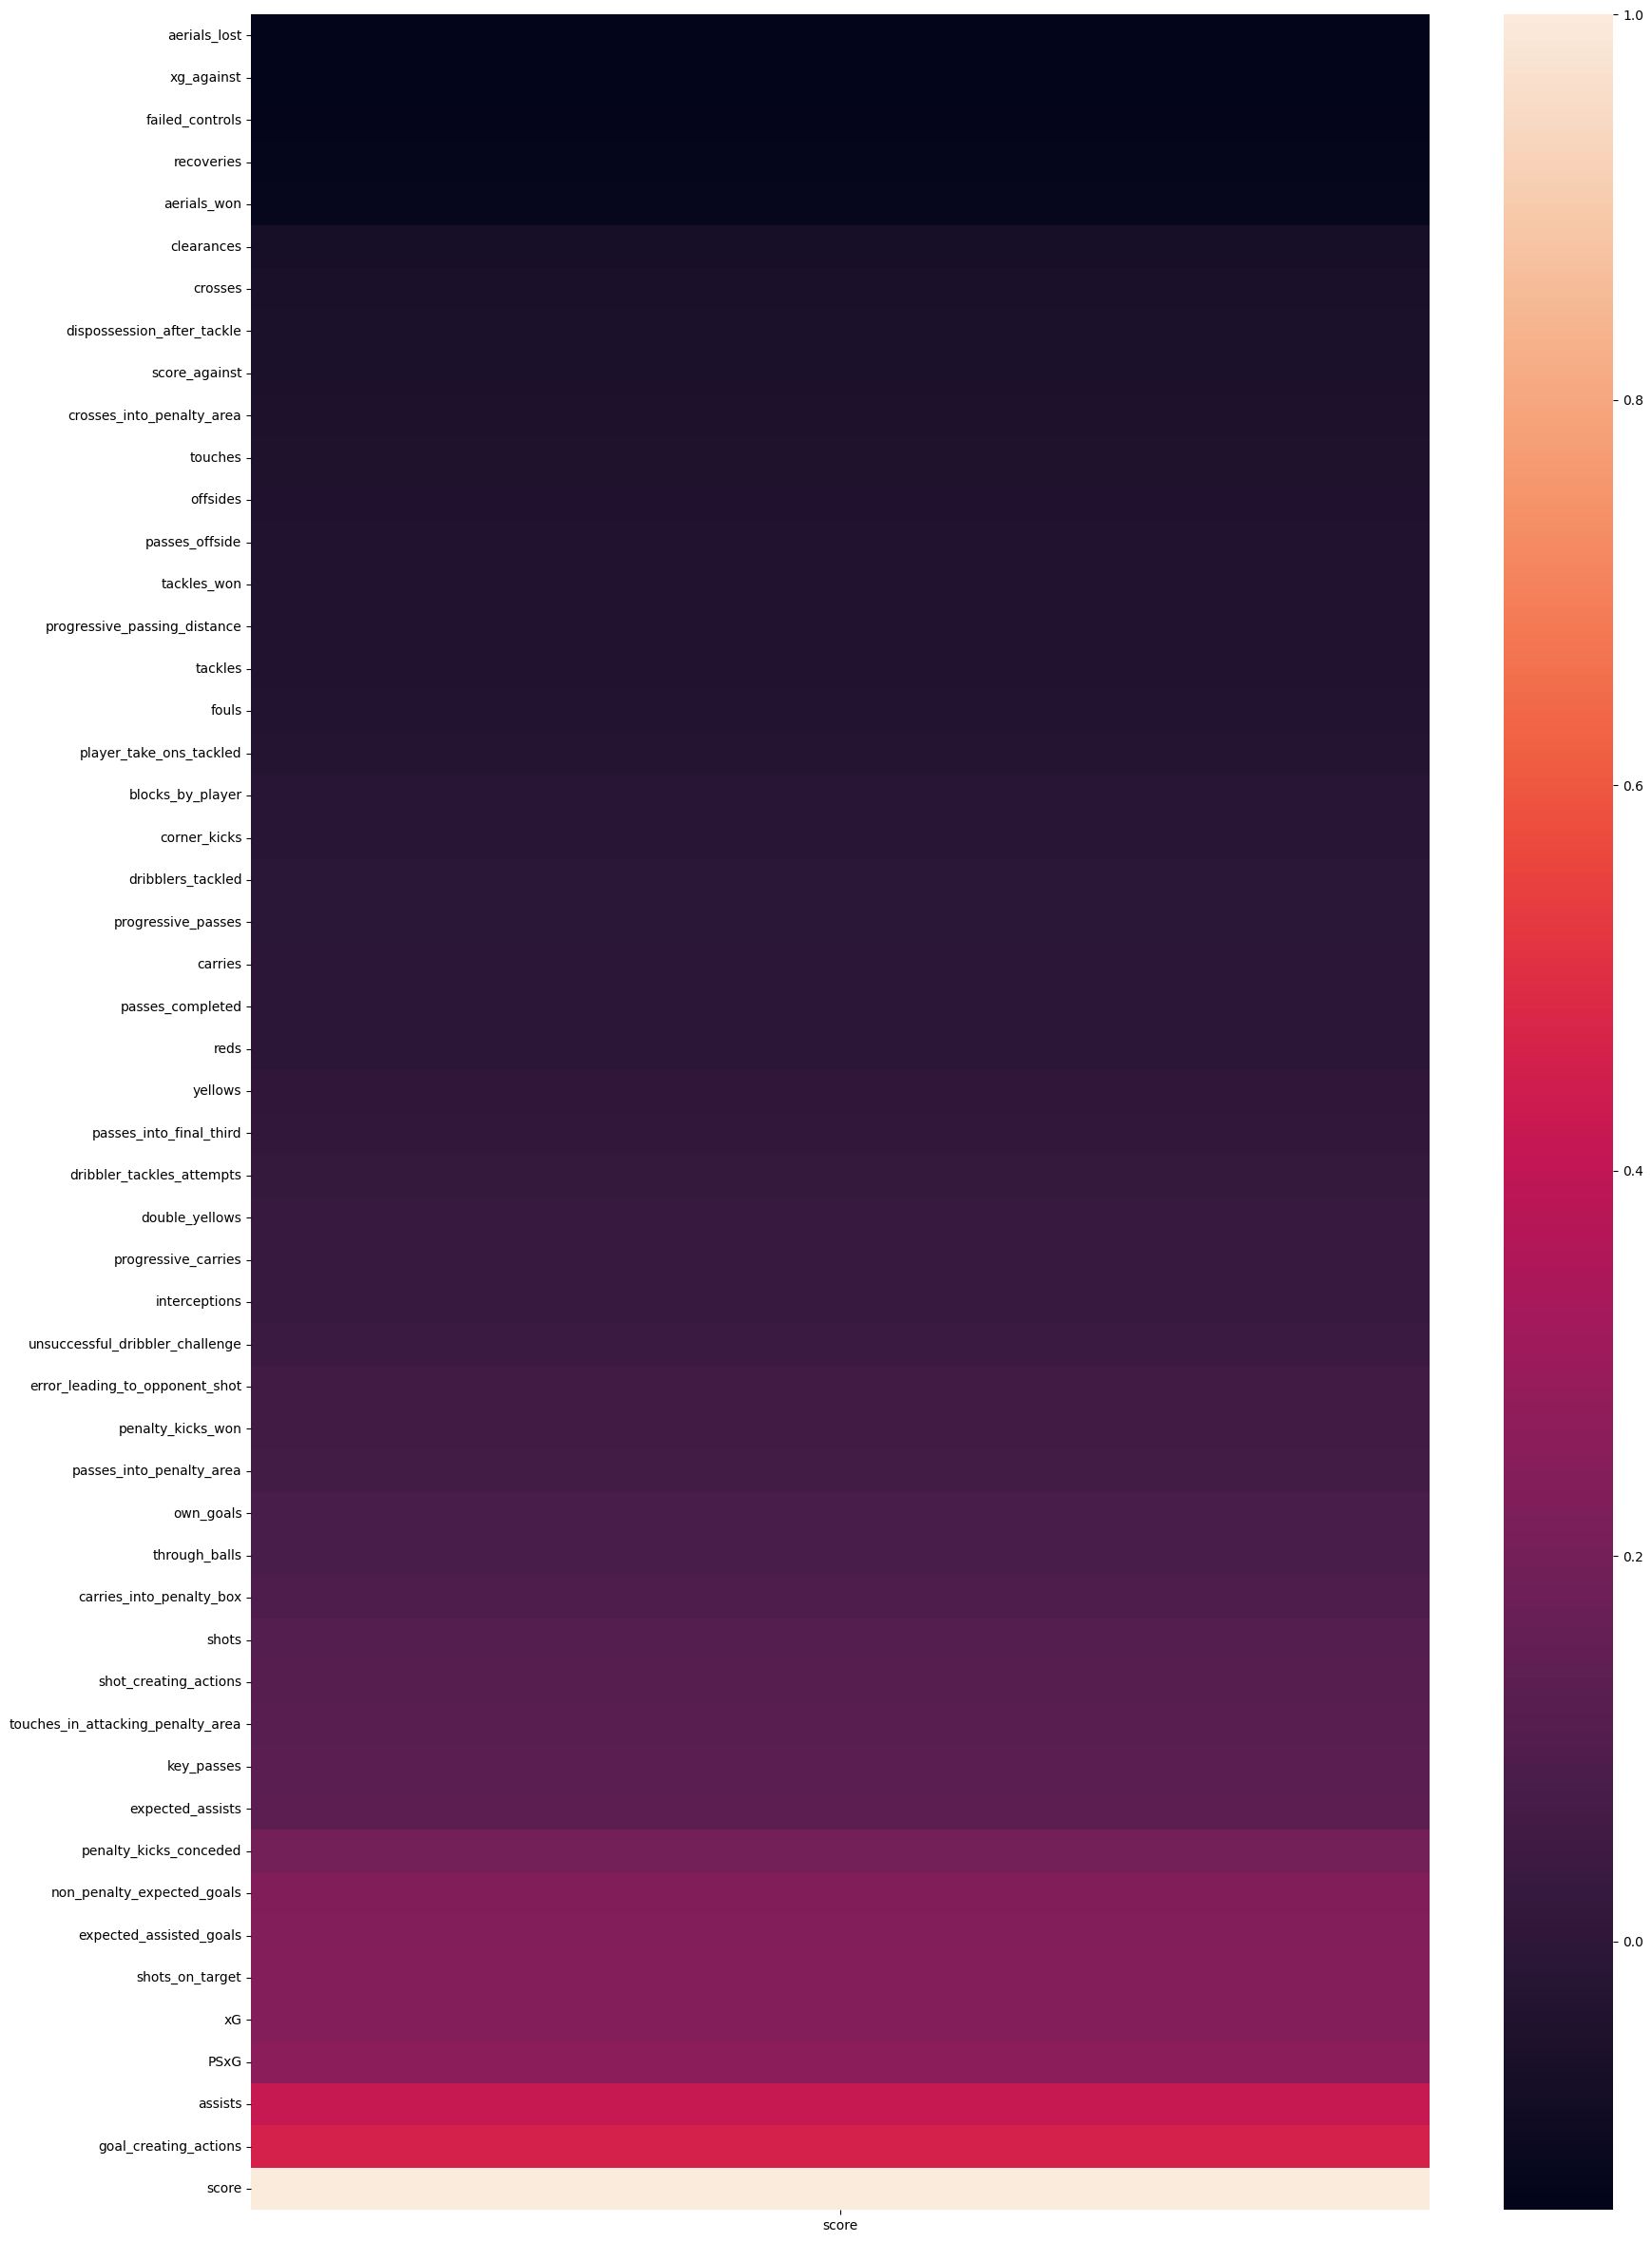

In [307]:
plt.subplots(figsize=(20,30))
sns.heatmap(x);